In [4]:
import sklearn.datasets
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import datasets as dt
import sys

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

/users/kent/stadiset/anaconda3/envs/cnn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


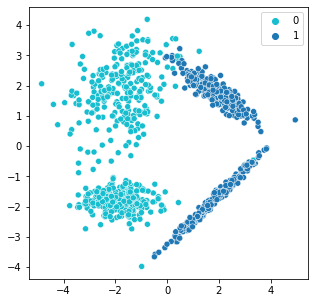

<class 'torch.Tensor'>


In [8]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
plt_ind_list = np.arange(3)+131

for class_sep,plt_ind in zip([1],plt_ind_list):
    X,y = dt.make_classification(n_samples=1000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=1.8,
                                 n_redundant=0,
                                 random_state=rand_state)
    palette = {0:"tab:cyan",
               1:"tab:blue", 
               }
    sns.scatterplot(X[:,0],X[:,1], hue = y, palette=palette )

plt.show()

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

print(type(y))

torch.Size([1000, 2])


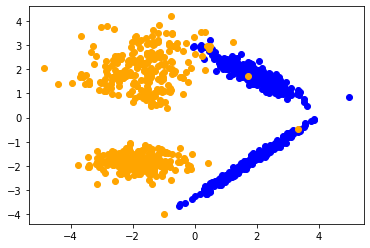

In [9]:
epsilon = 0.3
X2 = X.numpy()
b = np.logical_or( X2.dot(np.array([epsilon,1])) > 0 , X2.dot(np.array([epsilon,-1])) >0 )
X3 = X2[b,:]
y2 = y.numpy()
y3 = y2[b]
print(X.shape)

# X3, y = sklearn.datasets.make_circles(n_samples=1500, noise = 0.05, factor = 0.5)
# plt.scatter(X3[:,0],X3[:,1], color = 'b')
plt.scatter(X3[:, 0][y3==1],X3[:, 1][y3==1], color='b')
plt.scatter(X3[:, 0][y3==0],X3[:, 1][y3==0], color='orange')

torch.Size([1000, 2])


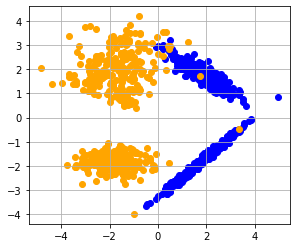

In [10]:
epsilon = 0.3
X2 = X.numpy()
y2 = y.numpy()
b = np.logical_or(X2.dot(np.array([epsilon,1])) > 0 , X2.dot(np.array([epsilon,-1])) >0 )
b = np.logical_and(b,y2==0)
b = np.logical_or(b, y2==1)
X3 = X2[b,:]

y3 = y2[b]
print(X.shape)

# X3, y = sklearn.datasets.make_circles(n_samples=1500, noise = 0.05, factor = 0.5)
# plt.scatter(X3[:,0],X3[:,1], color = 'b')
fig, axs = plt.subplots(1,1)
axs.set_aspect('equal')

axs.scatter(X3[:, 0][y3==1],X3[:, 1][y3==1], color='b')
axs.scatter(X3[:, 0][y3==0],X3[:, 1][y3==0], color='orange')

plt.grid()
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [12]:
# scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [13]:
EPOCHS = 1000
BATCH_SIZE = 5
LEARNING_RATE = 0.001

In [14]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(2, 2) 
        self.layer_2 = nn.Linear(2, 2)
        self.layer_3 = nn.Linear(2, 2)
        self.layer_out = nn.Linear(2, 1) 
        
        self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(64)
#         self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        
        return x

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [18]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (layer_1): Linear(in_features=2, out_features=2, bias=True)
  (layer_2): Linear(in_features=2, out_features=2, bias=True)
  (layer_3): Linear(in_features=2, out_features=2, bias=True)
  (layer_out): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)


In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [20]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.70450 | Acc: 49.851
Epoch 002: | Loss: 0.69986 | Acc: 49.851
Epoch 003: | Loss: 0.69714 | Acc: 49.851
Epoch 004: | Loss: 0.69576 | Acc: 49.851
Epoch 005: | Loss: 0.69480 | Acc: 49.851
Epoch 006: | Loss: 0.69433 | Acc: 49.851
Epoch 007: | Loss: 0.69391 | Acc: 49.851
Epoch 008: | Loss: 0.69364 | Acc: 49.851
Epoch 009: | Loss: 0.69346 | Acc: 49.851
Epoch 010: | Loss: 0.69342 | Acc: 49.851
Epoch 011: | Loss: 0.69337 | Acc: 49.851
Epoch 012: | Loss: 0.69332 | Acc: 49.851
Epoch 013: | Loss: 0.69325 | Acc: 49.851
Epoch 014: | Loss: 0.69332 | Acc: 48.358
Epoch 015: | Loss: 0.69329 | Acc: 49.104
Epoch 016: | Loss: 0.69342 | Acc: 45.970
Epoch 017: | Loss: 0.69330 | Acc: 49.104
Epoch 018: | Loss: 0.69326 | Acc: 48.806
Epoch 019: | Loss: 0.69323 | Acc: 46.119
Epoch 020: | Loss: 0.69327 | Acc: 50.149
Epoch 021: | Loss: 0.69331 | Acc: 47.015
Epoch 022: | Loss: 0.69328 | Acc: 50.149
Epoch 023: | Loss: 0.69329 | Acc: 50.149
Epoch 024: | Loss: 0.69328 | Acc: 46.269
Epoch 025: | Los

Epoch 201: | Loss: 0.69330 | Acc: 48.507
Epoch 202: | Loss: 0.69337 | Acc: 47.015
Epoch 203: | Loss: 0.69323 | Acc: 50.149
Epoch 204: | Loss: 0.69326 | Acc: 48.955
Epoch 205: | Loss: 0.69326 | Acc: 49.701
Epoch 206: | Loss: 0.69328 | Acc: 50.149
Epoch 207: | Loss: 0.69340 | Acc: 48.209
Epoch 208: | Loss: 0.69330 | Acc: 47.612
Epoch 209: | Loss: 0.69328 | Acc: 50.149
Epoch 210: | Loss: 0.69331 | Acc: 50.149
Epoch 211: | Loss: 0.69325 | Acc: 50.149
Epoch 212: | Loss: 0.69329 | Acc: 50.149
Epoch 213: | Loss: 0.69336 | Acc: 47.313
Epoch 214: | Loss: 0.69332 | Acc: 50.149
Epoch 215: | Loss: 0.69329 | Acc: 48.806
Epoch 216: | Loss: 0.69328 | Acc: 50.149
Epoch 217: | Loss: 0.69324 | Acc: 49.403
Epoch 218: | Loss: 0.69327 | Acc: 50.149
Epoch 219: | Loss: 0.69326 | Acc: 48.657
Epoch 220: | Loss: 0.69338 | Acc: 47.612
Epoch 221: | Loss: 0.69323 | Acc: 50.149
Epoch 222: | Loss: 0.69330 | Acc: 46.866
Epoch 223: | Loss: 0.69328 | Acc: 50.149
Epoch 224: | Loss: 0.69322 | Acc: 50.149
Epoch 225: | Los

Epoch 401: | Loss: 0.69330 | Acc: 50.149
Epoch 402: | Loss: 0.69321 | Acc: 46.866
Epoch 403: | Loss: 0.69326 | Acc: 48.358
Epoch 404: | Loss: 0.69329 | Acc: 47.015
Epoch 405: | Loss: 0.69330 | Acc: 50.149
Epoch 406: | Loss: 0.69344 | Acc: 47.463
Epoch 407: | Loss: 0.69326 | Acc: 50.299
Epoch 408: | Loss: 0.69335 | Acc: 48.358
Epoch 409: | Loss: 0.69327 | Acc: 50.149
Epoch 410: | Loss: 0.69323 | Acc: 50.149
Epoch 411: | Loss: 0.69338 | Acc: 47.164
Epoch 412: | Loss: 0.69325 | Acc: 50.149
Epoch 413: | Loss: 0.69331 | Acc: 50.149
Epoch 414: | Loss: 0.69327 | Acc: 50.149
Epoch 415: | Loss: 0.69327 | Acc: 50.149
Epoch 416: | Loss: 0.69328 | Acc: 50.149
Epoch 417: | Loss: 0.69332 | Acc: 49.403
Epoch 418: | Loss: 0.69321 | Acc: 50.149
Epoch 419: | Loss: 0.69325 | Acc: 48.657
Epoch 420: | Loss: 0.69331 | Acc: 48.209
Epoch 421: | Loss: 0.69326 | Acc: 48.955
Epoch 422: | Loss: 0.69342 | Acc: 48.955
Epoch 423: | Loss: 0.69327 | Acc: 50.149
Epoch 424: | Loss: 0.69324 | Acc: 50.149
Epoch 425: | Los

Epoch 601: | Loss: 0.69329 | Acc: 48.209
Epoch 602: | Loss: 0.69326 | Acc: 50.149
Epoch 603: | Loss: 0.69328 | Acc: 50.149
Epoch 604: | Loss: 0.69344 | Acc: 47.612
Epoch 605: | Loss: 0.69324 | Acc: 48.209
Epoch 606: | Loss: 0.69328 | Acc: 50.149
Epoch 607: | Loss: 0.69330 | Acc: 46.269
Epoch 608: | Loss: 0.69327 | Acc: 48.209
Epoch 609: | Loss: 0.69326 | Acc: 50.149
Epoch 610: | Loss: 0.69336 | Acc: 48.507
Epoch 611: | Loss: 0.69348 | Acc: 45.224
Epoch 612: | Loss: 0.69321 | Acc: 50.149
Epoch 613: | Loss: 0.69326 | Acc: 50.149
Epoch 614: | Loss: 0.69321 | Acc: 50.149
Epoch 615: | Loss: 0.69332 | Acc: 47.015
Epoch 616: | Loss: 0.69321 | Acc: 50.149
Epoch 617: | Loss: 0.69320 | Acc: 50.149
Epoch 618: | Loss: 0.69324 | Acc: 50.149
Epoch 619: | Loss: 0.69324 | Acc: 50.149
Epoch 620: | Loss: 0.69328 | Acc: 50.149
Epoch 621: | Loss: 0.69326 | Acc: 50.149
Epoch 622: | Loss: 0.69323 | Acc: 50.149
Epoch 623: | Loss: 0.69324 | Acc: 47.761
Epoch 624: | Loss: 0.69336 | Acc: 48.955
Epoch 625: | Los

Epoch 801: | Loss: 0.69328 | Acc: 47.761
Epoch 802: | Loss: 0.69324 | Acc: 50.149
Epoch 803: | Loss: 0.69330 | Acc: 50.149
Epoch 804: | Loss: 0.69326 | Acc: 48.955
Epoch 805: | Loss: 0.69328 | Acc: 47.761
Epoch 806: | Loss: 0.69327 | Acc: 50.149
Epoch 807: | Loss: 0.69323 | Acc: 50.149
Epoch 808: | Loss: 0.69326 | Acc: 47.015
Epoch 809: | Loss: 0.69323 | Acc: 50.149
Epoch 810: | Loss: 0.69332 | Acc: 45.672
Epoch 811: | Loss: 0.69320 | Acc: 50.149
Epoch 812: | Loss: 0.69323 | Acc: 50.149
Epoch 813: | Loss: 0.69324 | Acc: 50.149
Epoch 814: | Loss: 0.69324 | Acc: 47.761
Epoch 815: | Loss: 0.69327 | Acc: 50.149
Epoch 816: | Loss: 0.69332 | Acc: 50.149
Epoch 817: | Loss: 0.69322 | Acc: 50.149
Epoch 818: | Loss: 0.69323 | Acc: 50.149
Epoch 819: | Loss: 0.69326 | Acc: 48.209
Epoch 820: | Loss: 0.69325 | Acc: 50.149
Epoch 821: | Loss: 0.69328 | Acc: 50.149
Epoch 822: | Loss: 0.69327 | Acc: 50.149
Epoch 823: | Loss: 0.69330 | Acc: 50.149
Epoch 824: | Loss: 0.69340 | Acc: 49.403
Epoch 825: | Los

In [15]:
print(model.layer_1.weight)
print(model.layer_2.weight)
print(model.layer_3.weight)
print(model.layer_out.weight)

Parameter containing:
tensor([[0.0099, 0.0813],
        [0.1150, 0.3958]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.4636, -0.3398],
        [-0.6614,  0.2913]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.6992, -0.0432],
        [ 0.6868,  0.1772]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.3353, -0.1266]], device='cuda:0', requires_grad=True)


In [16]:
print(model.layer_1.bias)
print(model.layer_2.bias)
print(model.layer_3.bias)
print(model.layer_out.bias)

Parameter containing:
tensor([-0.5800,  0.4484], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0048, -0.2714], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.4713, -0.4984], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0966], device='cuda:0', requires_grad=True)
